In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from scipy.spatial.distance import cdist, pdist
from sklearn.neighbors import KDTree

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', dist="euclidean"):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.dist = dist
        self.X = None
        self.y = None
    
    def fit(self, X, y):
        
        if self.algorithm == 'brute':
            self.X = X
            self.y = y
            if self.dist == 'cosinus':
                X_norm = np.sqrt(np.sum(self.X ** 2, axis=1).T)
                self.X = self.X / X_norm[:,np.newaxis]
        elif self.algorithm == 'kd_tree':
            self.X = X
            self.tree = KDTree(X, leaf_size=2)
            #print(self.tree.query(np.array([[16, 24, 33]])))
            self.y = y
    
    def predict(self, X):
        if self.algorithm == 'brute':
            if self.dist == 'euclidean':
                diff = self.X - X[:,np.newaxis,:]
                euclid_dist = np.sqrt(np.sum(diff**2, axis=2).T)
                y_temp = self.y[np.argsort(euclid_dist, axis=0)].T
                predict = np.array([np.bincount(row).argmax() for row in y_temp[:,:self.n_neighbors]])
                #print(predict)
                print('brute')
                return predict
            elif self.dist == 'cosinus':
                X_norm = np.sqrt(np.sum(X ** 2, axis=1).T)
                X = X / X_norm.reshape((X_norm.shape[0], 1))
                diff = self.X - X[:,np.newaxis,:]
                euclid_dist = np.sqrt(np.sum(diff**2, axis=2).T)
                
                cosin_dist = (euclid_dist ** 2) / 2
                y_temp = self.y[np.argsort(cosin_dist, axis=0)].T
                predict = np.array([np.bincount(row).argmax() for row in y_temp[:,:self.n_neighbors]])
                #print(predict)
                print('brute')
                return predict
        elif self.algorithm == 'kd_tree':
            dist, ind = self.tree.query(X, k=self.n_neighbors)
            print ('kd_tree')
            y_temp = self.y[ind]
            predict = np.array([np.bincount(row).argmax() for row in y_temp[:,:self.n_neighbors]])
            return predict
       
        
    

In [3]:
myN = MyKNeighborsClassifier(3, 'brute', 'cosinus')
X = np.array([[1, 1, 2], [0, 0, 7],[6, 8, 8], [10, 22, 13],[54, 35, 87], [16, 24, 33]])
X_test_my = np.array([[1, 1, 2],[16, 24, 33], [10, 22, 13]])
y = np.array([1, 2, 1, 0, 2, 0])
print(y.shape)
myN.fit(X, y)
print(myN.predict(X_test_my))


(6,)
brute
[0 1 0]


Проверим алгоритм на датасете Ирисы Фишера из библиотеки scikit-learn

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(15, 4)
(15,)
(135, 4)
(135,)


In [7]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [8]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [9]:
my_clf_pred = my_clf.predict(X_test)

print(my_clf_pred)

brute
[1 1 1 2 2 0 0 2 0 1 0 0 1 2 2]


In [10]:
sklearn_pred = clf.predict(X_test)
print(sklearn_pred)

[1 1 1 2 2 0 0 2 0 1 0 0 1 2 2]


In [11]:
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

Попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris

In [12]:
%time clf.fit(X_train, y_train)

CPU times: user 3.92 ms, sys: 3.77 ms, total: 7.69 ms
Wall time: 4.13 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [13]:
%time my_clf.fit(X_train, y_train)

CPU times: user 6 µs, sys: 6 µs, total: 12 µs
Wall time: 16.2 µs


In [14]:
%time clf.predict(X_test)

CPU times: user 12.6 ms, sys: 2.43 ms, total: 15 ms
Wall time: 8.16 ms


array([1, 1, 1, 2, 2, 0, 0, 2, 0, 1, 0, 0, 1, 2, 2])

In [15]:
%time my_clf.predict(X_test)

brute
CPU times: user 613 µs, sys: 10.6 ms, total: 11.3 ms
Wall time: 8.59 ms


array([1, 1, 1, 2, 2, 0, 0, 2, 0, 1, 0, 0, 1, 2, 2])

Добавим algorithm='kd_tree' в реализацию KNN и попробуем добиться скорости работы на fit,  predict сравнимой со sklearn для iris.  

In [16]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [18]:
%time clf.fit(X_train, y_train)

CPU times: user 20.3 ms, sys: 99 µs, total: 20.4 ms
Wall time: 16 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [19]:
%time my_clf.fit(X_train, y_train)

CPU times: user 765 µs, sys: 729 µs, total: 1.49 ms
Wall time: 1.01 ms


In [20]:
%time clf.predict(X_test)

CPU times: user 12.2 ms, sys: 1.98 ms, total: 14.2 ms
Wall time: 9 ms


array([2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 1])

In [21]:
%time my_clf.predict(X_test)

kd_tree
CPU times: user 2.48 ms, sys: 2.34 ms, total: 4.82 ms
Wall time: 2.76 ms


array([2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 1])

In [22]:
sklearn_pred = clf.predict(X_test)
sklearn_pred

array([2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 1])

In [23]:
my_clf_pred = my_clf.predict(X_test)
my_clf_pred

kd_tree


array([2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 1])

In [24]:
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

Рассмотрим новый датасет 20 newsgroups

In [25]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [26]:
data = newsgroups['data']
target = newsgroups['target']

In [27]:
print(len(data))

11314


Преобразуем текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). И ограничим словарь по частотности.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [55]:
vectorizer_train = CountVectorizer(max_df = 0.5, min_df = 0.1)
data_vect = vectorizer_train.fit_transform(data)
print(data_vect.toarray())

[[0 0 1 ... 0 1 0]
 [0 0 0 ... 0 1 1]
 [1 1 1 ... 0 1 0]
 ...
 [1 1 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [59]:
x = [1]
print(len(vectorizer_train.get_feature_names()))

104


In [31]:
names = vectorizer.get_feature_names()
target.shape

(11314,)

Реализуем разбиение выборки для кросс-валидации на 3 фолдах с помощью sklearn.cross_validation. И посчитаем скоры для разного числа соседей

In [151]:
mean_scor = []
for i in range(1, 10):
    my_clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    scores = cross_val_score(my_clf, data_vect.toarray(), target, cv=3, scoring='f1_macro')
    mean_scor.append(scores.mean())

kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree
kd_tree


In [153]:
mean_scor

[0.13534676738808346,
 0.11099168164201317,
 0.10976315068623878,
 0.11704639108071135,
 0.12029826856639782,
 0.12296509620944322,
 0.12408723595958933,
 0.12242294728675714,
 0.12047924263651427]

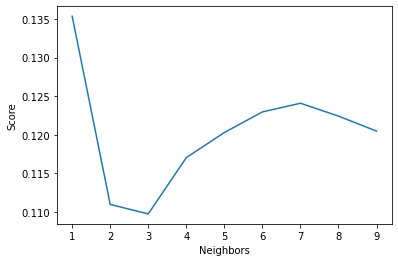

In [159]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9], mean_scor)
plt.ylabel('Score')
plt.xlabel('Neighbors')
plt.show()

Теперь преобразуем test  часть нашей выборки аналогично с train частью

In [34]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [35]:
data_test = newsgroups['data']
target_test = newsgroups['target']
vectorizer = CountVectorizer(max_df = 0.5, min_df = 0.1)
data_test_vec = vectorizer.fit_transform(data_test)
print(data_vect.toarray())

[[0 0 1 ... 0 1 0]
 [0 0 0 ... 0 1 1]
 [1 1 1 ... 0 1 0]
 ...
 [1 1 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [43]:
print(data_test_vec.shape)
print(target_test.shape)

(7532, 103)
(7532,)


In [125]:
print(data_vect.shape)
# print(len(vectorizer.get_feature_names()))

intersect = list(set(vectorizer.get_feature_names()) & set(vectorizer_train.get_feature_names()))
# print(sorted(intersect))
data_train_int = data_vect.toarray()[:,np.where(np.in1d(vectorizer_train.get_feature_names(), intersect))][:,0,:]
print(data_train_int.shape)
# print(np.where(np.in1d(vectorizer.get_feature_names(), intersect)))
data_test_int = data_test_vec.toarray()[:,np.where(np.in1d(vectorizer.get_feature_names(), intersect))][:,0,:]
print(target_test.shape)

(11314, 104)
(11314, 100)
(7532,)


Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [160]:
my_clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='kd_tree', dist='cosinus')
my_clf.fit(data_train_int, target)

In [161]:
pred = my_clf.predict(data_test_int)

kd_tree


In [162]:
print(pred[:15])
print(target_test[:15])
accuracy_score(target_test, pred)

[10 12 11  0  9 17 15 12  0  5  6 13 18 11  0]
[ 7  5  0 17 19 13 15 15  5  1  2  5 17  8  0]


0.11776420605416887